# Deep Learning with PyTorch Step-by-Step: A Beginner's Guide

# Chapter 11

## Additional Setup

In [1]:
# !pip install gensim==3.8.3
# !pip install allennlp==0.9.0
# !pip install flair==0.8.0.post1 # uses PyTorch 1.7.1
# # HuggingFace
# !pip install transformers==4.5.1
# !pip install datasets==1.6.0

In [1]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)    
except ModuleNotFoundError:
    pass

from config import *
config_chapter11()
# This is needed to render the plots in this chapter
from plots.chapter11 import *

In [1]:
import os
import json
import errno
import requests
import numpy as np
from copy import deepcopy
from operator import itemgetter

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset

from data_generation.nlp import ALICE_URL, WIZARD_URL, download_text
from stepbystep.v4 import StepByStep
# These are the classes we built in Chapter 10
from seq2seq import *

import nltk
from nltk.tokenize import sent_tokenize

import gensim
from gensim import corpora, downloader
from gensim.parsing.preprocessing import *
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec

from flair.data import Sentence
from flair.embeddings import ELMoEmbeddings, WordEmbeddings, \
    TransformerWordEmbeddings, TransformerDocumentEmbeddings

from datasets import load_dataset, Split
from transformers import (
    DataCollatorForLanguageModeling,
    BertModel, BertTokenizer, BertForSequenceClassification,
    DistilBertModel, DistilBertTokenizer, 
    DistilBertForSequenceClassification,
    AutoModelForSequenceClassification,
    AutoModel, AutoTokenizer, AutoModelForCausalLM,
    Trainer, TrainingArguments, pipeline, TextClassificationPipeline
)
from transformers.pipelines import SUPPORTED_TASKS

# Down the Yellow Brick Rabbit Hole

![](images/alice_dorothy.png)

*Left: "Alice and the Baby Pig" illustration by John Tenniel's, from "Alice's Adventure's in Wonderland" (1865).*

*Right: "Dorothy meets the Cowardly Lion" illustration by W.W. Denslow, from "The Wonderful Wizard of Oz" (1900)*

# Building a Dataset

In [3]:
localfolder = 'texts'
download_text(ALICE_URL, localfolder)
download_text(WIZARD_URL, localfolder)

In [4]:
with open(os.path.join(localfolder, 'alice28-1476.txt'), 'r') as f:
    alice = ''.join(f.readlines()[104:3704])
    
with open(os.path.join(localfolder, 'wizoz10-1740.txt'), 'r') as f:
    wizard = ''.join(f.readlines()[310:5100])

In [5]:
print(alice[:500])
print('\n')
print(wizard[:500])

                ALICE'S ADVENTURES IN WONDERLAND

                          Lewis Carroll

               THE MILLENNIUM FULCRUM EDITION 2.8




                            CHAPTER I

                      Down the Rabbit-Hole


  Alice was beginning to get very tired of sitting by her sister
on the bank, and of having nothing to do:  once or twice she had
peeped into the book her sister was reading, but it had no
pictures or conversations in it, `and what is the use of a book,'
thought Alice `w


                    THE WONDERFUL WIZARD OF OZ


                          1.  The Cyclone


    Dorothy lived in the midst of the great Kansas prairies, with
Uncle Henry, who was a farmer, and Aunt Em, who was the farmer's
wife.  Their house was small, for the lumber to build it had to be
carried by wagon many miles.  There were four walls, a floor and a
roof, which made one room; and this room contained a rusty looking
cookstove, a cupboard for the dishes, a table, three or four
chairs, and

In [6]:
text_cfg = """fname,start,end
alice28-1476.txt,104,3704
wizoz10-1740.txt,310,5100"""
bytes_written = open(os.path.join(localfolder, 'lines.cfg'), 'w').write(text_cfg)

## Sentence Tokenization

In [7]:
sentence = "I'm following the white rabbit"
tokens = sentence.split(' ')
tokens

["I'm", 'following', 'the', 'white', 'rabbit']

In [8]:
import nltk
from nltk.tokenize import sent_tokenize

nltk.download('punkt')
corpus_alice = sent_tokenize(alice)
corpus_wizard = sent_tokenize(wizard)
len(corpus_alice), len(corpus_wizard)

[nltk_data] Downloading package punkt to /home/dvgodoy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


(1612, 2240)

In [9]:
corpus_alice[2]

'There was nothing so VERY remarkable in that; nor did Alice\nthink it so VERY much out of the way to hear the Rabbit say to\nitself, `Oh dear!'

In [10]:
corpus_wizard[30]

'"There\'s a cyclone coming, Em," he called to his wife.'

In [11]:
def sentence_tokenize(source, quote_char='\\', sep_char=',',
                      include_header=True, include_source=True, 
                      extensions=('txt'), **kwargs):
    nltk.download('punkt')
    # If source is a folder, goes through all files inside it
    # that match the desired extensions ('txt' by default)
    if os.path.isdir(source):
        filenames = [f for f in os.listdir(source)
                     if os.path.isfile(os.path.join(source, f)) and
                        os.path.splitext(f)[1][1:] in extensions]
    elif isinstance(source, str):
        filenames = [source]
    
    # If there is a configuration file, builds a dictionary with
    # the corresponding start and end lines of each text file
    config_file = os.path.join(source, 'lines.cfg')
    config = {}
    if os.path.exists(config_file):
        with open(config_file, 'r') as f:
            rows = f.readlines()

        for r in rows[1:]:
            fname, start, end = r.strip().split(',')
            config.update({fname: (int(start), int(end))})
       
    new_fnames = []
    # For each file of text
    for fname in filenames:
        # If there's a start and end line for that file, use it
        try:
            start, end = config[fname]
        except KeyError:
            start = None
            end = None
            
        # Opens the file, slices the configures lines (if any)
        # cleans line breaks and uses the sentence tokenizer
        with open(os.path.join(source, fname), 'r') as f:
            contents = (''.join(f.readlines()[slice(start, end, None)])
                        .replace('\n', ' ').replace('\r', ''))
        corpus = sent_tokenize(contents, **kwargs)
        
        # Builds a CSV file containing tokenized sentences
        base = os.path.splitext(fname)[0]
        new_fname = f'{base}.sent.csv'
        new_fname = os.path.join(source, new_fname)
        with open(new_fname, 'w') as f:
            # Header of the file
            if include_header:
                if include_source:
                    f.write('sentence,source\n')
                else:
                    f.write('sentence\n')
            # Writes one line for each sentence
            for sentence in corpus:
                if include_source:
                    f.write(f'{quote_char}{sentence}{quote_char}{sep_char}{fname}\n')
                else:
                    f.write(f'{quote_char}{sentence}{quote_char}\n')
        new_fnames.append(new_fname)
        
    # Returns list of the newly generated CSV files
    return sorted(new_fnames)

In [12]:
new_fnames = sentence_tokenize(localfolder)
new_fnames

[nltk_data] Downloading package punkt to /home/dvgodoy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['texts/alice28-1476.sent.csv', 'texts/wizoz10-1740.sent.csv']

In [13]:
# import spacy
# nlp = spacy.blank("en")
# nlp.add_pipe(nlp.create_pipe("sentencizer"))

# sentences = []
# for doc in nlp.pipe(corpus_alice):
#     sentences.extend(sent.text for sent in doc.sents)
    
# len(sentences), sentences[2]

## HuggingFace's Dataset

## Loading a Dataset

In [14]:
from datasets import load_dataset, Split

dataset = load_dataset(path='csv', data_files=new_fnames, quotechar='\\', split=Split.TRAIN)

Using custom data configuration default-5f3dd563caa0ef2a


Dataset csv downloaded and prepared to /home/dvgodoy/.cache/huggingface/datasets/csv/default-5f3dd563caa0ef2a/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0. Subsequent calls will reuse this data.


### Attributes

In [15]:
dataset.features, dataset.num_columns, dataset.shape

({'sentence': Value(dtype='string', id=None),
  'source': Value(dtype='string', id=None)},
 2,
 (3852, 2))

In [16]:
dataset[2]

{'sentence': 'There was nothing so VERY remarkable in that; nor did Alice think it so VERY much out of the way to hear the Rabbit say to itself, `Oh dear!',
 'source': 'alice28-1476.txt'}

In [17]:
dataset['source'][:3]

['alice28-1476.txt', 'alice28-1476.txt', 'alice28-1476.txt']

### Methods

In [18]:
dataset.unique('source')

['alice28-1476.txt', 'wizoz10-1740.txt']

In [19]:
def is_alice_label(row):
    is_alice = int(row['source'] == 'alice28-1476.txt')
    return {'labels': is_alice}

dataset = dataset.map(is_alice_label)

In [20]:
dataset[2]

{'labels': 1,
 'sentence': 'There was nothing so VERY remarkable in that; nor did Alice think it so VERY much out of the way to hear the Rabbit say to itself, `Oh dear!',
 'source': 'alice28-1476.txt'}

In [21]:
shuffled_dataset = dataset.shuffle(seed=42)

In [22]:
split_dataset = shuffled_dataset.train_test_split(test_size=0.2)
split_dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'sentence', 'source'],
        num_rows: 3081
    })
    test: Dataset({
        features: ['labels', 'sentence', 'source'],
        num_rows: 771
    })
})

In [23]:
train_dataset, test_dataset = split_dataset['train'], split_dataset['test']

## Data Augmentation

In [24]:
# !pip install textattack
# from textattack.augmentation import EmbeddingAugmenter
# augmenter = EmbeddingAugmenter()
# feynman = 'What I cannot create, I do not understand.'

In [25]:
# for i in range(5):
#     print(augmenter.augment(feynman))

# Word Tokenization

In [26]:
sentence = "I'm following the white rabbit"
tokens = sentence.split(' ')
tokens

["I'm", 'following', 'the', 'white', 'rabbit']

In [27]:
from gensim.parsing.preprocessing import *

preprocess_string(sentence)

['follow', 'white', 'rabbit']

In [28]:
filters = [lambda x: x.lower(), strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric]
preprocess_string(sentence, filters=filters)

['i', 'm', 'following', 'the', 'white', 'rabbit']

In [29]:
from gensim.utils import simple_preprocess

tokens = simple_preprocess(sentence)
tokens

['following', 'the', 'white', 'rabbit']

## Vocabulary

In [30]:
sentences = train_dataset['sentence']
tokens = [simple_preprocess(sent) for sent in sentences]
tokens[0]

['and', 'so', 'far', 'as', 'they', 'knew', 'they', 'were', 'quite', 'right']

In [31]:
from gensim import corpora

dictionary = corpora.Dictionary(tokens)
print(dictionary)

Dictionary(3704 unique tokens: ['and', 'as', 'far', 'knew', 'quite']...)


In [32]:
dictionary.num_docs

3081

In [33]:
dictionary.num_pos # processed words

50802

In [34]:
dictionary.token2id

{'and': 0,
 'as': 1,
 'far': 2,
 'knew': 3,
 'quite': 4,
 'right': 5,
 'so': 6,
 'they': 7,
 'were': 8,
 'beginning': 9,
 'begun': 10,
 'cried': 11,
 'cry': 12,
 'gryphon': 13,
 'had': 14,
 'it': 15,
 'just': 16,
 'mock': 17,
 'of': 18,
 'repeat': 19,
 'the': 20,
 'to': 21,
 'trial': 22,
 'turtle': 23,
 'when': 24,
 'across': 25,
 'at': 26,
 'broad': 27,
 'but': 28,
 'could': 29,
 'deep': 30,
 'he': 31,
 'leap': 32,
 'lion': 33,
 'not': 34,
 'once': 35,
 'one': 36,
 'that': 37,
 'this': 38,
 'was': 39,
 'are': 40,
 'do': 41,
 'me': 42,
 'seek': 43,
 'who': 44,
 'why': 45,
 'you': 46,
 'destroy': 47,
 'for': 48,
 'her': 49,
 'mean': 50,
 'perhaps': 51,
 'said': 52,
 'scarecrow': 53,
 'we': 54,
 'alice': 55,
 'afterward': 56,
 'city': 57,
 'emerald': 58,
 'gate': 59,
 'into': 60,
 'on': 61,
 'passed': 62,
 'through': 63,
 'added': 64,
 'care': 65,
 'chin': 66,
 'digging': 67,
 'duchess': 68,
 'is': 69,
 'little': 70,
 'means': 71,
 'moral': 72,
 'much': 73,
 'same': 74,
 'sense': 75,
 's

In [35]:
vocab = list(dictionary.token2id.keys())
vocab[:5]

['and', 'as', 'far', 'knew', 'quite']

In [36]:
dictionary.cfs

{0: 2024,
 6: 362,
 2: 29,
 1: 473,
 7: 443,
 3: 36,
 8: 231,
 4: 65,
 5: 45,
 11: 36,
 20: 3725,
 13: 46,
 17: 46,
 23: 49,
 14: 360,
 16: 72,
 10: 8,
 21: 1481,
 19: 5,
 15: 811,
 24: 172,
 12: 12,
 18: 1107,
 22: 9,
 9: 14,
 28: 369,
 38: 230,
 36: 189,
 39: 693,
 27: 5,
 30: 12,
 37: 550,
 33: 140,
 26: 383,
 35: 77,
 31: 466,
 29: 161,
 34: 297,
 32: 2,
 25: 15,
 44: 144,
 40: 143,
 46: 706,
 45: 67,
 41: 160,
 43: 6,
 42: 220,
 51: 22,
 52: 613,
 53: 173,
 48: 390,
 54: 154,
 50: 10,
 47: 6,
 49: 502,
 55: 305,
 56: 3,
 62: 20,
 61: 278,
 63: 56,
 59: 13,
 60: 121,
 58: 52,
 57: 66,
 71: 9,
 73: 82,
 74: 33,
 82: 59,
 68: 34,
 67: 4,
 76: 17,
 70: 199,
 66: 8,
 78: 4,
 77: 749,
 64: 27,
 72: 7,
 69: 292,
 80: 37,
 65: 12,
 75: 4,
 79: 3,
 83: 158,
 81: 10,
 85: 293,
 91: 37,
 86: 145,
 88: 681,
 89: 19,
 90: 12,
 87: 7,
 92: 72,
 84: 34,
 93: 104,
 94: 254,
 95: 5,
 101: 18,
 108: 4,
 113: 50,
 106: 40,
 110: 3,
 100: 13,
 111: 3,
 109: 22,
 104: 122,
 97: 3,
 105: 11,
 99: 43,
 

In [37]:
dictionary.dfs

{0: 1306,
 6: 351,
 2: 27,
 1: 338,
 7: 342,
 3: 34,
 8: 201,
 4: 61,
 5: 45,
 11: 36,
 20: 1884,
 13: 45,
 17: 46,
 23: 48,
 14: 315,
 16: 72,
 10: 8,
 21: 1072,
 19: 5,
 15: 609,
 24: 165,
 12: 12,
 18: 833,
 22: 9,
 9: 14,
 28: 358,
 38: 225,
 36: 175,
 39: 550,
 27: 5,
 30: 12,
 37: 491,
 33: 138,
 26: 345,
 35: 75,
 31: 366,
 29: 153,
 34: 267,
 32: 2,
 25: 14,
 44: 140,
 40: 132,
 46: 549,
 45: 67,
 41: 157,
 43: 6,
 42: 193,
 51: 22,
 52: 605,
 53: 173,
 48: 358,
 54: 131,
 50: 10,
 47: 6,
 49: 371,
 55: 295,
 56: 3,
 62: 20,
 61: 260,
 63: 55,
 59: 12,
 60: 115,
 58: 52,
 57: 65,
 71: 9,
 73: 81,
 74: 33,
 82: 57,
 68: 32,
 67: 4,
 76: 17,
 70: 188,
 66: 7,
 78: 4,
 77: 498,
 64: 27,
 72: 7,
 69: 263,
 80: 36,
 65: 11,
 75: 4,
 79: 3,
 83: 138,
 81: 10,
 85: 288,
 91: 36,
 86: 135,
 88: 590,
 89: 19,
 90: 11,
 87: 7,
 92: 70,
 84: 33,
 93: 103,
 94: 206,
 95: 5,
 101: 18,
 108: 4,
 113: 50,
 106: 39,
 110: 3,
 100: 13,
 111: 3,
 109: 22,
 104: 116,
 97: 3,
 105: 11,
 99: 41,
 1

In [38]:
sentence = 'follow the white rabbit'
new_tokens = simple_preprocess(sentence)
ids = dictionary.doc2idx(new_tokens)
print(new_tokens)
print(ids)

['follow', 'the', 'white', 'rabbit']
[1482, 20, 497, 333]


In [39]:
special_tokens = {'[PAD]': 0, '[UNK]': 1}
dictionary.patch_with_special_tokens(special_tokens)

In [40]:
def get_rare_ids(dictionary, min_freq):
    rare_ids = [t[0] for t in dictionary.cfs.items() if t[1] < min_freq]
    return rare_ids

In [41]:
def make_vocab(sentences, folder=None, special_tokens=None, vocab_size=None, min_freq=None):
    if folder is not None:
        if not os.path.exists(folder):
            os.mkdir(folder)
            
    # tokenizes the sentences and create a Dictionary
    tokens = [simple_preprocess(sent) for sent in sentences]
    dictionary = corpora.Dictionary(tokens)
    # keeps only the most frequent words (vocab size)
    if vocab_size is not None:
        dictionary.filter_extremes(keep_n=vocab_size)
    # removes rare words (in case the vocab size still
    # includes words with low frequency)
    if min_freq is not None:
        rare_tokens = get_rare_ids(dictionary, min_freq)
        dictionary.filter_tokens(bad_ids=rare_tokens)
    # gets the whole list of tokens and frequencies
    items = dictionary.cfs.items()
    # sorts the tokens in descending order
    words = [dictionary[t[0]] for t in sorted(dictionary.cfs.items(), key=lambda t: -t[1])]
    # prepends special tokens, if any
    if special_tokens is not None:
        to_add = []
        for special_token in special_tokens:
            if special_token not in words:
                to_add.append(special_token)
        words = to_add + words
                
    with open(os.path.join(folder, 'vocab.txt'), 'w') as f:
        for word in words:
            f.write(f'{word}\n')

In [42]:
make_vocab(train_dataset['sentence'], 'our_vocab/', special_tokens=['[PAD]', '[UNK]', '[SEP]', '[CLS]', '[MASK]'], min_freq=2)

## HugginFace's Tokenizer

In [43]:
from transformers import BertTokenizer

tokenizer = BertTokenizer('our_vocab/vocab.txt')

In [44]:
new_sentence = 'follow the white rabbit neo'
new_tokens = tokenizer.tokenize(new_sentence)
new_tokens

['follow', 'the', 'white', 'rabbit', '[UNK]']

In [45]:
new_ids = tokenizer.convert_tokens_to_ids(new_tokens)
new_ids

[1219, 5, 229, 200, 1]

In [46]:
new_ids = tokenizer.encode(new_sentence)
new_ids

[3, 1219, 5, 229, 200, 1, 2]

In [47]:
tokenizer.convert_ids_to_tokens(new_ids)

['[CLS]', 'follow', 'the', 'white', 'rabbit', '[UNK]', '[SEP]']

In [48]:
tokenizer.encode(new_sentence, add_special_tokens=False)

[1219, 5, 229, 200, 1]

In [49]:
tokenizer(new_sentence, add_special_tokens=False, return_tensors='pt')

{'input_ids': tensor([[1219,    5,  229,  200,    1]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}

In [50]:
sentence1 = 'follow the white rabbit neo'
sentence2 = 'no one can be told what the matrix is'
joined_sentences = tokenizer(sentence1, sentence2)
joined_sentences

{'input_ids': [3, 1219, 5, 229, 200, 1, 2, 51, 42, 78, 32, 307, 41, 5, 1, 30, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [51]:
print(tokenizer.convert_ids_to_tokens(joined_sentences['input_ids']))

['[CLS]', 'follow', 'the', 'white', 'rabbit', '[UNK]', '[SEP]', 'no', 'one', 'can', 'be', 'told', 'what', 'the', '[UNK]', 'is', '[SEP]']


In [52]:
separate_sentences = tokenizer([sentence1, sentence2], padding=True)
separate_sentences

{'input_ids': [[3, 1219, 5, 229, 200, 1, 2, 0, 0, 0, 0], [3, 51, 42, 78, 32, 307, 41, 5, 1, 30, 2]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [53]:
print(tokenizer.convert_ids_to_tokens(separate_sentences['input_ids'][0]))
print(separate_sentences['attention_mask'][0])

['[CLS]', 'follow', 'the', 'white', 'rabbit', '[UNK]', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]


In [54]:
first_sentences = [sentence1, 'another first sentence']
second_sentences = [sentence2, 'a second sentence here']
batch_of_pairs = tokenizer(first_sentences, second_sentences)
first_input = tokenizer.convert_ids_to_tokens(batch_of_pairs['input_ids'][0])
second_input = tokenizer.convert_ids_to_tokens(batch_of_pairs['input_ids'][1])
print(first_input)
print(second_input)

['[CLS]', 'follow', 'the', 'white', 'rabbit', '[UNK]', '[SEP]', 'no', 'one', 'can', 'be', 'told', 'what', 'the', '[UNK]', 'is', '[SEP]']
['[CLS]', 'another', 'first', 'sentence', '[SEP]', '[UNK]', 'second', 'sentence', 'here', '[SEP]']


In [55]:
tokenized_dataset = tokenizer(dataset['sentence'], 
                              padding=True, 
                              return_tensors='pt', 
                              max_length=50, 
                              truncation=True)
tokenized_dataset['input_ids']

tensor([[   3,   27,    1,  ...,   86,  870,    2],
        [   3,   24,   10,  ..., 1573,    5,    2],
        [   3,   49,   12,  ...,    0,    0,    0],
        ...,
        [   3,    1,    6,  ...,    0,    0,    0],
        [   3,    6,  132,  ...,    0,    0,    0],
        [   3,    1,    1,  ...,    0,    0,    0]])

# Before Word Embeddings

## One-Hot Encoding (OHE)

![](images/ohe1.png)

![](images/ohe2.png)

## Bag of Words (BoW)

In [56]:
sentence = 'the white rabbit is a rabbit'
bow_tokens = simple_preprocess(sentence)
bow_tokens

['the', 'white', 'rabbit', 'is', 'rabbit']

In [57]:
bow = dictionary.doc2bow(bow_tokens)
bow

[(20, 1), (69, 1), (333, 2), (497, 1)]

## Language Models

![](images/blank1.png)

![](images/blank2.png)

![](images/fill1.png)

![](images/fill2.png)

## N-grams

![](images/ngrams.png)

## Continuous Bag-of-Words (CBoW)

![](images/blank_end.png)

![](images/blank_center.png)

# Word Embeddings

## Word2Vec

![](images/cbow.png)

In [58]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.linear = nn.Linear(embedding_size, vocab_size)
        
    def forward(self, X):
        embeddings = self.embedding(X)
        bow = embeddings.mean(dim=1)
        logits = self.linear(bow)
        return logits

In [59]:
torch.manual_seed(42)
dummy_cbow = CBOW(vocab_size=5, embedding_size=3)
dummy_cbow.embedding.state_dict()

OrderedDict([('weight',
              tensor([[ 0.3367,  0.1288,  0.2345],
                      [ 0.2303, -1.1229, -0.1863],
                      [ 2.2082, -0.6380,  0.4617],
                      [ 0.2674,  0.5349,  0.8094],
                      [ 1.1103, -1.6898, -0.9890]]))])

![](images/w2v_embed.png)

In [60]:
# tokens: ['is', 'barking']
dummy_cbow.embedding(torch.as_tensor([2, 3]))

tensor([[ 2.2082, -0.6380,  0.4617],
        [ 0.2674,  0.5349,  0.8094]], grad_fn=<EmbeddingBackward>)

In [61]:
tiny_vocab = ['the', 'small', 'is', 'barking', 'dog']
context_words = ['the', 'small', 'is', 'barking']
target_words = ['dog']

In [62]:
batch_context = torch.as_tensor([[0, 1, 2, 3]]).long()
batch_target = torch.as_tensor([4]).long()

![](images/w2v_cbow.png)

In [63]:
cbow_features = dummy_cbow.embedding(batch_context).mean(dim=1)
cbow_features

tensor([[ 0.7606, -0.2743,  0.3298]], grad_fn=<MeanBackward1>)

![](images/w2v_logits.png)

In [64]:
logits = dummy_cbow.linear(cbow_features)
logits

tensor([[ 0.3542,  0.6937, -0.2028, -0.5873,  0.2099]],
       grad_fn=<AddmmBackward>)

## What is an Embeddings Anyway?

![](images/rest_discrete.png)

![](images/rest_continuous.png)

In [65]:
ratings = torch.as_tensor([[.7, -.4, .7],
                           [.3, .7, -.5],
                           [.9, -.55, .8],
                           [-.3, .8, .34]]).float()
sims = torch.zeros(4, 4)
for i in range(4):
    for j in range(4):
        sims[i, j] = F.cosine_similarity(ratings[i], ratings[j], dim=0)
sims

tensor([[ 1.0000, -0.4318,  0.9976, -0.2974],
        [-0.4318,  1.0000, -0.4270,  0.3581],
        [ 0.9976, -0.4270,  1.0000, -0.3598],
        [-0.2974,  0.3581, -0.3598,  1.0000]])

## Pre-trained Word2Vec

## Global Vectors (GloVe)

In [66]:
from gensim import downloader

glove = downloader.load('glove-wiki-gigaword-50')
len(glove.vocab)

400000

In [67]:
glove['alice']

array([ 0.16386 ,  0.57795 , -0.59197 , -0.32446 ,  0.29762 ,  0.85151 ,
       -0.76695 , -0.20733 ,  0.21491 , -0.51587 , -0.17517 ,  0.94459 ,
        0.12705 , -0.33031 ,  0.75951 ,  0.44449 ,  0.16553 , -0.19235 ,
        0.065533, -0.12394 ,  0.61446 ,  0.89784 ,  0.17413 ,  0.41149 ,
        1.191   , -0.39461 , -0.459   ,  0.022161, -0.50843 , -0.44464 ,
        0.68721 , -0.7167  ,  0.20835 , -0.23437 ,  0.02604 , -0.47993 ,
        0.31873 , -0.29135 ,  0.50273 , -0.55144 , -0.066692,  0.43873 ,
       -0.24293 , -1.0247  ,  0.029375,  0.068499,  0.25451 , -1.9663  ,
        0.26673 ,  0.88486 ], dtype=float32)

In [68]:
synthetic_queen = glove['king'] - glove['man'] + glove['woman']

/home/dvgodoy/projects/PyTorchStepByStep/plots/chapter11.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels(['', word, ''])


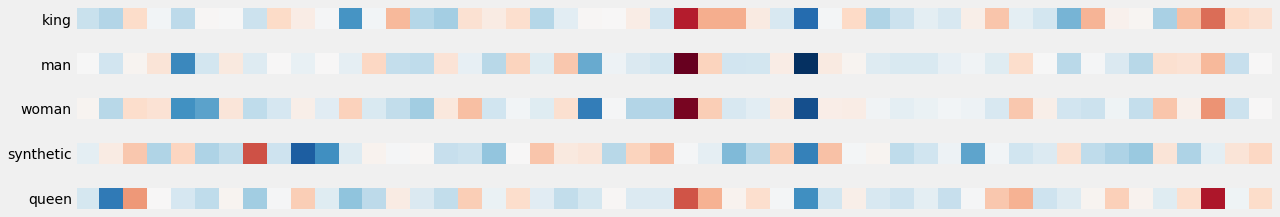

In [69]:
fig = plot_word_vectors(glove, 
                        ['king', 'man', 'woman', 'synthetic', 'queen'],
                        other={'synthetic': synthetic_queen})

In [70]:
glove.similar_by_vector(synthetic_queen, topn=5)

[('king', 0.8859835863113403),
 ('queen', 0.8609581589698792),
 ('daughter', 0.7684512138366699),
 ('prince', 0.7640699148178101),
 ('throne', 0.7634971141815186)]

![](images/embed_arithmetic.png)

$$
\Large
w_{\text{king}} - w_{\text{man}}\approx w_{\text{queen}}-w_{\text{woman}} \implies w_{\text{king}} - w_{\text{man}} + w_{\text{woman}} \approx w_{\text{queen}}
$$

## Using Word Embeddings

### Vocabulary Coverage

In [71]:
vocab = list(dictionary.token2id.keys())
len(vocab)

3706

In [72]:
unknown_words = sorted(list(set(vocab).difference(set(glove.vocab))))
print(len(unknown_words))
print(unknown_words[:5])

44
['[PAD]', '[UNK]', 'arrum', 'barrowful', 'beauti']


In [73]:
unknown_ids = [dictionary.token2id[w] for w in unknown_words if w not in ['[PAD]', '[UNK]']]
unknown_count = np.sum([dictionary.cfs[idx] for idx in unknown_ids])
unknown_count, dictionary.num_pos

(82, 50802)

In [74]:
def vocab_coverage(gensim_dict, pretrained_wv, special_tokens=('[PAD]', '[UNK]')):
    vocab = list(gensim_dict.token2id.keys())
    unknown_words = sorted(list(set(vocab).difference(set(pretrained_wv.vocab))))
    unknown_ids = [gensim_dict.token2id[w] for w in unknown_words if w not in special_tokens]
    unknown_count = np.sum([gensim_dict.cfs[idx] for idx in unknown_ids])
    cov = 1 - unknown_count / gensim_dict.num_pos
    return cov

In [75]:
vocab_coverage(dictionary, glove)

0.9983858903192788

### Tokenizer

In [76]:
def make_vocab_from_wv(wv, folder=None, special_tokens=None):
    if folder is not None:
        if not os.path.exists(folder):
            os.mkdir(folder)

    words = wv.index2word
    if special_tokens is not None:
        to_add = []
        for special_token in special_tokens:
            if special_token not in words:
                to_add.append(special_token)
        words = to_add + words
                
    with open(os.path.join(folder, 'vocab.txt'), 'w') as f:
        for word in words:
            f.write(f'{word}\n')    

In [77]:
make_vocab_from_wv(glove, 'glove_vocab/', special_tokens=['[PAD]', '[UNK]'])

In [78]:
glove_tokenizer = BertTokenizer('glove_vocab/vocab.txt')

In [79]:
glove_tokenizer.encode('alice followed the white rabbit', add_special_tokens=False)

[7101, 930, 2, 300, 12427]

In [80]:
len(glove_tokenizer.vocab), len(glove.vectors)

(400002, 400000)

### Special Tokens' Embeddings

In [81]:
special_embeddings = np.zeros((2, glove.vector_size))

In [82]:
extended_embeddings = np.concatenate([special_embeddings, glove.vectors], axis=0)
extended_embeddings.shape

(400002, 50)

In [83]:
alice_idx = glove_tokenizer.encode('alice', add_special_tokens=False)
np.all(extended_embeddings[alice_idx] == glove['alice'])

True

## Model I - GloVe + Classifier

### Data Preparation

In [84]:
train_sentences = train_dataset['sentence']
train_labels = train_dataset['labels']

test_sentences = test_dataset['sentence']
test_labels = test_dataset['labels']

In [85]:
train_ids = glove_tokenizer(train_sentences, 
                            truncation=True,
                            padding=True, 
                            max_length=60, 
                            add_special_tokens=False, 
                            return_tensors='pt')['input_ids']
train_labels = torch.as_tensor(train_labels).float().view(-1, 1)

test_ids = glove_tokenizer(test_sentences, 
                           truncation=True,
                           padding=True, 
                           max_length=60, 
                           add_special_tokens=False, 
                           return_tensors='pt')['input_ids']
test_labels = torch.as_tensor(test_labels).float().view(-1, 1)

In [86]:
train_tensor_dataset = TensorDataset(train_ids, train_labels)
generator = torch.Generator()
train_loader = DataLoader(train_tensor_dataset, batch_size=32, shuffle=True, generator=generator)
test_tensor_dataset = TensorDataset(test_ids, test_labels)
test_loader = DataLoader(test_tensor_dataset, batch_size=32)

### Pre-Trained PyTorch Embeddings

In [87]:
extended_embeddings = torch.as_tensor(extended_embeddings).float()
torch_embeddings = nn.Embedding.from_pretrained(extended_embeddings)

In [88]:
token_ids, labels = next(iter(train_loader))
token_ids

tensor([[  36,   63,    1,  ...,    0,    0,    0],
        [ 934,   16,   14,  ...,    0,    0,    0],
        [  57,  311,    8,  ...,  140,    3,   83],
        ...,
        [7101,   59, 1536,  ...,    0,    0,    0],
        [  43,   59, 1995,  ...,    0,    0,    0],
        [ 102,   41,  210,  ...,  685,    3,    7]])

In [89]:
token_embeddings = torch_embeddings(token_ids)
token_embeddings.shape

torch.Size([32, 60, 50])

In [90]:
token_embeddings.mean(dim=1)

tensor([[ 0.0665, -0.0071, -0.0534,  ..., -0.1906, -0.0202, -0.1432],
        [ 0.0514,  0.0495,  0.0083,  ..., -0.0272,  0.0162,  0.0687],
        [ 0.2431,  0.1981, -0.0282,  ..., -0.2559, -0.0252,  0.0176],
        ...,
        [-0.0018,  0.0598,  0.0083,  ..., -0.0792,  0.0222,  0.0261],
        [ 0.0516,  0.1091,  0.0917,  ..., -0.0851,  0.0037,  0.0553],
        [ 0.1972,  0.1069, -0.2049,  ..., -0.4969, -0.1026, -0.3731]])

In [91]:
boe_mean = nn.EmbeddingBag.from_pretrained(extended_embeddings, mode='mean')
boe_mean(token_ids)

tensor([[ 0.0665, -0.0071, -0.0534,  ..., -0.1906, -0.0202, -0.1432],
        [ 0.0514,  0.0495,  0.0083,  ..., -0.0272,  0.0162,  0.0687],
        [ 0.2431,  0.1981, -0.0282,  ..., -0.2559, -0.0252,  0.0176],
        ...,
        [-0.0018,  0.0598,  0.0083,  ..., -0.0792,  0.0222,  0.0261],
        [ 0.0516,  0.1091,  0.0917,  ..., -0.0851,  0.0037,  0.0553],
        [ 0.1972,  0.1069, -0.2049,  ..., -0.4969, -0.1026, -0.3731]])

### Model Configuration & Training

In [92]:
extended_embeddings = torch.as_tensor(extended_embeddings).float()
boe_mean = nn.EmbeddingBag.from_pretrained(
    extended_embeddings, mode='mean'
)
torch.manual_seed(41)
model = nn.Sequential(
    # Embeddings
    boe_mean,
    # Classifier
    nn.Linear(boe_mean.embedding_dim, 128), 
    nn.ReLU(),
    nn.Linear(128, 1)
)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [93]:
sbs_emb = StepByStep(model, loss_fn, optimizer)
sbs_emb.set_loaders(train_loader, test_loader)
sbs_emb.train(20)

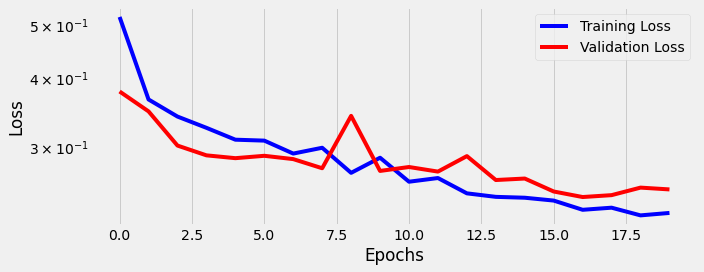

In [94]:
fig = sbs_emb.plot_losses()

In [96]:
StepByStep.loader_apply(test_loader, sbs_emb.correct)

tensor([[380, 440],
        [311, 331]])

## Model II - GloVe + Transformer

In [97]:
class TransfClassifier(nn.Module):
    def __init__(self, embedding_layer, encoder, n_outputs):
        super().__init__()
        self.d_model = encoder.d_model
        self.n_outputs = n_outputs
        self.encoder = encoder
        self.mlp = nn.Linear(self.d_model, n_outputs)

        self.embed = embedding_layer
        self.cls_token = nn.Parameter(torch.zeros(1, 1, self.d_model))
            
    def preprocess(self, X):
        # N, L -> N, L, D
        src = self.embed(X)
        # Special classifier token
        # 1, 1, D -> N, 1, D
        cls_tokens = self.cls_token.expand(X.size(0), -1, -1)
        # Concatenates CLS tokens -> N, 1 + L, D
        src = torch.cat((cls_tokens, src), dim=1)
        return src
    
    def encode(self, source, source_mask=None):
        # Encoder generates "hidden states"
        states = self.encoder(source, source_mask)
        # Gets state from first token only: [CLS]
        cls_state = states[:, 0]  # N, 1, D
        return cls_state
    
    @staticmethod
    def source_mask(X):
        cls_mask = torch.ones(X.size(0), 1).type_as(X)
        pad_mask = torch.cat((cls_mask, X > 0), dim=1).bool()
        return pad_mask.unsqueeze(1)
        
    def forward(self, X):
        src = self.preprocess(X)
        # Featurizer
        cls_state = self.encode(src, self.source_mask(X))
        # Classifier
        out = self.mlp(cls_state) # N, 1, outputs
        return out

In [98]:
torch.manual_seed(33)
# Loads the pretrained GloVe embeddings into an embedding layer
torch_embeddings = nn.Embedding.from_pretrained(extended_embeddings)
# Creates a Transformer Encoder
layer = EncoderLayer(n_heads=2, d_model=torch_embeddings.embedding_dim, ff_units=128)
encoder = EncoderTransf(layer, n_layers=1)
# Uses both layers above to build our model
model = TransfClassifier(torch_embeddings, encoder, n_outputs=1)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [99]:
sbs_transf = StepByStep(model, loss_fn, optimizer)
sbs_transf.set_loaders(train_loader, test_loader)
sbs_transf.train(10)

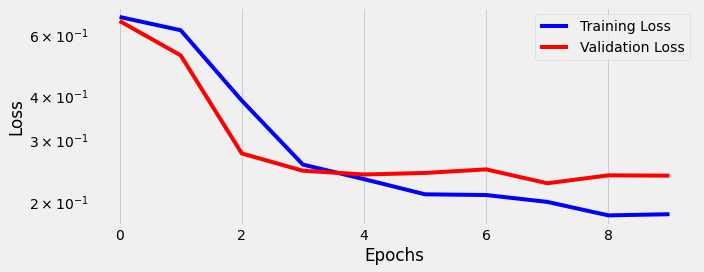

In [100]:
fig = sbs_transf.plot_losses()

In [101]:
StepByStep.loader_apply(test_loader, sbs_transf.correct)

tensor([[410, 440],
        [300, 331]])

### Visualizing Attention

In [102]:
sentences = ['The white rabbit and Alice ran away', 'The lion met Dorothy on the road']
inputs = glove_tokenizer(sentences, add_special_tokens=False, return_tensors='pt')['input_ids']
inputs = inputs.to(sbs_transf.device)
inputs

tensor([[    2,   300, 12427,     7,  7101,  1423,   422],
        [    2,  6659,   811, 11238,    15,     2,   588]], device='cuda:0')

In [103]:
sbs_transf.model.eval()
out = sbs_transf.model(inputs)
# our model outputs logits, so we turn them into probs
torch.sigmoid(out)

tensor([[0.9888],
        [0.0101]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [104]:
alphas = sbs_transf.model.encoder.layers[0].self_attn_heads.alphas
alphas[:, :, 0, :].squeeze()

tensor([[[2.6334e-01, 6.9912e-02, 1.6958e-01, 1.6574e-01, 1.1365e-01,
          1.3449e-01, 6.6508e-02, 1.6772e-02],
         [2.7878e-05, 2.5806e-03, 2.9353e-03, 1.3467e-01, 1.7490e-03,
          8.5641e-01, 7.3843e-04, 8.8371e-04]],

        [[6.8102e-02, 1.8080e-02, 1.0238e-01, 6.1889e-02, 6.2652e-01,
          1.0388e-02, 1.6588e-02, 9.6055e-02],
         [2.2783e-04, 2.1089e-02, 3.4972e-01, 2.3252e-02, 5.2879e-01,
          3.5840e-02, 2.5432e-02, 1.5650e-02]]], device='cuda:0')

<ipython-input-107-a1f395f91ca0>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['', f'Head #{i}', ''])


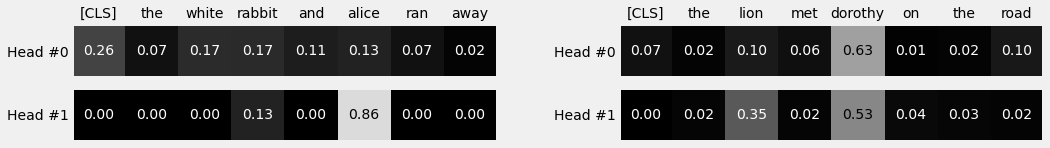

In [107]:
tokens = [['[CLS]'] + glove_tokenizer.tokenize(sent) for sent in sentences]
fig = plot_attention(tokens, alphas)

# Contextual Word Embeddings

## ELMo

In [137]:
watch1 = """
The Hatter was the first to break the silence. `What day of the month is it?' he said, turning to Alice:  he had taken his watch out of his pocket, and was looking at it uneasily, shaking it every now and then, and holding it to his ear.
"""

watch2 = """
Alice thought this a very curious thing, and she went nearer to watch them, and just as she came up to them she heard one of them say, `Look out now, Five!  Don't go splashing paint over me like that!
"""

sentences = [watch1, watch2]

In [138]:
from flair.data import Sentence

flair_sentences = [Sentence(s) for s in sentences]
flair_sentences[0]

Sentence: "The Hatter was the first to break the silence . ` What day of the month is it ? ' he said , turning to Alice : he had taken his watch out of his pocket , and was looking at it uneasily , shaking it every now and then , and holding it to his ear ."   [− Tokens: 58]

In [139]:
flair_sentences[0].get_token(32)

Token: 32 watch

In [140]:
flair_sentences[0].tokens[31]

Token: 32 watch

In [141]:
from flair.embeddings import ELMoEmbeddings
elmo = ELMoEmbeddings()

In [142]:
elmo.embed(flair_sentences)

[Sentence: "The Hatter was the first to break the silence . ` What day of the month is it ? ' he said , turning to Alice : he had taken his watch out of his pocket , and was looking at it uneasily , shaking it every now and then , and holding it to his ear ."   [− Tokens: 58],
 Sentence: "Alice thought this a very curious thing , and she went nearer to watch them , and just as she came up to them she heard one of them say , ` Look out now , Five ! Do n't go splashing paint over me like that !"   [− Tokens: 48]]

In [143]:
token_watch1 = flair_sentences[0].tokens[31]
token_watch2 = flair_sentences[1].tokens[13]
token_watch1, token_watch2

(Token: 32 watch, Token: 14 watch)

In [144]:
token_watch1.embedding, token_watch2.embedding

(tensor([-0.5047, -0.4183,  0.0910,  ...,  2.4156, -0.2228,  0.7794],
        device='cuda:0'),
 tensor([-0.5047, -0.4183,  0.0910,  ...,  0.2134,  0.8352, -0.5018],
        device='cuda:0'))

### Where do ELMo Embeddings come from?

![](images/elmo_lstm.png)

![](images/elmo_embed.png)

In [145]:
token_watch1.embedding[0], token_watch1.embedding[512]

(tensor(-0.5047, device='cuda:0'), tensor(-0.5047, device='cuda:0'))

In [146]:
(token_watch1.embedding[:1024] == token_watch2.embedding[:1024]).all()

tensor(True, device='cuda:0')

In [147]:
similarity = nn.CosineSimilarity(dim=0, eps=1e-6)
similarity(token_watch1.embedding, token_watch2.embedding)

tensor(0.5949, device='cuda:0')

In [148]:
def get_embeddings(embeddings, sentence):
    sent = Sentence(sentence)
    embeddings.embed(sent)
    return torch.stack([token.embedding for token in sent.tokens]).float()

In [149]:
get_embeddings(elmo, watch1)

tensor([[-0.3288,  0.2022, -0.5940,  ..., -0.0425,  1.0605,  0.2637],
        [-0.7142,  0.4210, -0.9504,  ...,  0.3226, -0.6685,  1.7245],
        [ 0.2981, -0.0738, -0.1319,  ...,  0.3250,  1.1165,  0.6453],
        ...,
        [ 0.0475,  0.2325, -0.2013,  ...,  0.7386, -0.5294, -0.8543],
        [ 0.1599,  0.6898,  0.2946,  ...,  1.5656,  0.9583,  1.0337],
        [-0.8872, -0.2004, -1.0601,  ..., -0.0166, -0.0841,  0.0618]],
       device='cuda:0')

## GloVe

In [150]:
from flair.embeddings import WordEmbeddings
glove_embedding = WordEmbeddings('glove')

In [151]:
new_flair_sentences = [Sentence(s) for s in sentences]
glove_embedding.embed(new_flair_sentences)

[Sentence: "The Hatter was the first to break the silence . ` What day of the month is it ? ' he said , turning to Alice : he had taken his watch out of his pocket , and was looking at it uneasily , shaking it every now and then , and holding it to his ear ."   [− Tokens: 58],
 Sentence: "Alice thought this a very curious thing , and she went nearer to watch them , and just as she came up to them she heard one of them say , ` Look out now , Five ! Do n't go splashing paint over me like that !"   [− Tokens: 48]]

In [152]:
torch.all(new_flair_sentences[0].tokens[31].embedding == new_flair_sentences[1].tokens[13].embedding)

tensor(True, device='cuda:0')

## BERT

In [153]:
from flair.embeddings import TransformerWordEmbeddings
bert_flair = TransformerWordEmbeddings('bert-base-uncased', layers='-1')

In [154]:
embed1 = get_embeddings(bert_flair, watch1)
embed2 = get_embeddings(bert_flair, watch2)
embed2

tensor([[ 0.6554, -0.3799, -0.2842,  ...,  0.0601,  0.8865,  0.4760],
        [-0.1459, -0.0204, -0.0615,  ..., -0.0257,  0.5052,  0.3324],
        [-0.0436, -0.0401, -0.0135,  ...,  0.3920,  0.5231,  0.9067],
        ...,
        [-0.2582,  0.6933,  0.2688,  ..., -0.0325,  0.0772,  0.2187],
        [-0.1868,  0.6398, -0.8127,  ..., -0.5957,  0.2793,  0.1880],
        [-0.1021,  0.5222, -0.7142,  ...,  0.3644,  0.0600, -0.1419]],
       device='cuda:0')

In [155]:
bert_watch1 = embed1[31]
bert_watch2 = embed2[13]
bert_watch1, bert_watch2

(tensor([ 8.5760e-01,  3.5888e-01, -3.7825e-01, -8.3564e-01,  1.3528e+00,
          1.0204e-01, -8.2618e-01,  3.1570e-01,  3.1091e-01, -4.2653e-01,
          1.6632e-01,  7.2439e-02, -1.0276e+00,  4.4680e-01, -1.4549e-01,
          1.8315e-01,  3.7484e-01, -4.0245e-01, -1.4190e-01, -5.1596e-01,
          1.1984e+00,  6.8202e-01,  1.1028e+00, -4.3955e-02,  1.6932e-02,
          7.4420e-01, -1.0604e-01,  3.8719e-01,  7.3662e-02,  2.2424e-01,
         -5.0281e-02,  1.9586e-01,  1.0773e+00,  1.0341e+00,  4.4217e-01,
         -6.5567e-01, -5.6308e-01, -1.1827e-01,  1.2862e-01,  4.6581e-01,
         -7.1305e-01, -1.5682e-01, -1.3552e-01,  4.5852e-02,  8.2853e-03,
          5.2762e-01,  1.6906e+00,  5.5388e-01, -7.3778e-02,  5.1504e-01,
         -2.0619e-01, -2.9505e-03,  2.5389e-01, -1.5379e-01,  8.4900e-01,
          6.5440e-01, -3.2925e-01, -1.1198e+00,  2.4251e-01,  1.5586e-01,
          5.7514e-01,  8.5832e-02,  3.3306e-01, -3.9344e-01, -4.1766e-01,
          1.0790e+00,  1.1719e-02,  7.

In [156]:
similarity = nn.CosineSimilarity(dim=0, eps=1e-6)
similarity(bert_watch1, bert_watch2)

tensor(0.3504, device='cuda:0')

## Document Embeddings

In [157]:
documents = [Sentence(watch1), Sentence(watch2)]

In [158]:
from flair.embeddings import TransformerDocumentEmbeddings
bert_doc = TransformerDocumentEmbeddings('bert-base-uncased')
bert_doc.embed(documents)

[Sentence: "The Hatter was the first to break the silence . ` What day of the month is it ? ' he said , turning to Alice : he had taken his watch out of his pocket , and was looking at it uneasily , shaking it every now and then , and holding it to his ear ."   [− Tokens: 58],
 Sentence: "Alice thought this a very curious thing , and she went nearer to watch them , and just as she came up to them she heard one of them say , ` Look out now , Five ! Do n't go splashing paint over me like that !"   [− Tokens: 48]]

In [159]:
documents[0].embedding

tensor([-6.4245e-02,  3.5365e-01, -2.4962e-01, -5.3912e-01, -1.9917e-01,
        -2.7712e-01,  1.6942e-01,  1.0867e-01, -4.0799e-01, -1.4945e-01,
         4.4678e-02, -1.9687e-01, -3.0574e-01,  9.6215e-02,  2.8053e-01,
         9.0462e-01, -3.0250e-01,  1.7854e-01, -1.6856e-01, -1.7227e-01,
        -1.8270e-01,  4.5121e-01,  3.6128e-01,  1.2310e-01, -1.2047e-02,
        -5.0255e-01,  4.2645e-01, -3.7184e-02, -1.7052e-01, -4.8920e-02,
         1.0503e-01,  3.3456e-01, -3.8483e-02, -4.7287e-01, -7.4431e-02,
         2.3990e-01, -8.3232e-02,  1.7974e-01,  4.8939e-01,  9.3019e-03,
        -4.2722e-01,  2.6337e-01, -1.3216e-01, -1.3950e-01, -1.1859e-01,
         4.5834e-02, -3.9031e+00, -1.0726e-01,  5.1103e-02, -9.9710e-02,
         1.5913e-01, -9.5331e-02,  2.1513e-01,  4.7707e-01,  2.1226e-01,
         4.3450e-01, -4.5154e-01,  1.8344e-01, -1.0171e-01, -3.6373e-01,
         8.9560e-01,  3.5931e-01, -2.8519e-01,  2.9427e-02,  3.3968e-01,
         4.1062e-01, -2.1050e-02,  2.7802e-02,  2.8

In [160]:
documents[0].tokens[31].embedding

tensor([], device='cuda:0')

In [161]:
def get_embeddings(embeddings, sentence):
    sent = Sentence(sentence)
    embeddings.embed(sent)
    if len(sent.embedding):
        return sent.embedding.float()
    else:
        return torch.stack([token.embedding for token in sent.tokens]).float()

In [162]:
get_embeddings(bert_doc, watch1)

tensor([-6.4245e-02,  3.5365e-01, -2.4962e-01, -5.3912e-01, -1.9917e-01,
        -2.7712e-01,  1.6942e-01,  1.0867e-01, -4.0799e-01, -1.4945e-01,
         4.4678e-02, -1.9687e-01, -3.0574e-01,  9.6215e-02,  2.8053e-01,
         9.0462e-01, -3.0250e-01,  1.7854e-01, -1.6856e-01, -1.7227e-01,
        -1.8270e-01,  4.5121e-01,  3.6128e-01,  1.2310e-01, -1.2047e-02,
        -5.0255e-01,  4.2645e-01, -3.7184e-02, -1.7052e-01, -4.8920e-02,
         1.0503e-01,  3.3456e-01, -3.8483e-02, -4.7287e-01, -7.4431e-02,
         2.3990e-01, -8.3232e-02,  1.7974e-01,  4.8939e-01,  9.3019e-03,
        -4.2722e-01,  2.6337e-01, -1.3216e-01, -1.3950e-01, -1.1859e-01,
         4.5834e-02, -3.9031e+00, -1.0726e-01,  5.1103e-02, -9.9710e-02,
         1.5913e-01, -9.5331e-02,  2.1513e-01,  4.7707e-01,  2.1226e-01,
         4.3450e-01, -4.5154e-01,  1.8344e-01, -1.0171e-01, -3.6373e-01,
         8.9560e-01,  3.5931e-01, -2.8519e-01,  2.9427e-02,  3.3968e-01,
         4.1062e-01, -2.1050e-02,  2.7802e-02,  2.8

## Model III - Preprocessing Embeddings

### Data Preparation

In [163]:
train_dataset_doc = train_dataset.map(lambda row: {'embeddings': get_embeddings(bert_doc, row['sentence'])})
test_dataset_doc = test_dataset.map(lambda row: {'embeddings': get_embeddings(bert_doc, row['sentence'])})

In [164]:
train_dataset_doc.set_format(type='torch', columns=['embeddings', 'labels'])
test_dataset_doc.set_format(type='torch', columns=['embeddings', 'labels'])

In [165]:
train_dataset_doc['embeddings']

tensor([[-0.2932,  0.2595, -0.1252,  ..., -0.2407,  0.2998,  0.1157],
        [ 0.4934,  0.0129, -0.1991,  ...,  0.6354,  0.6320,  0.7036],
        [-0.6256, -0.3536, -0.4682,  ...,  0.5507,  0.2467,  0.6108],
        ...,
        [-0.5786,  0.0274, -0.1081,  ..., -0.0108,  0.0329,  0.9563],
        [ 0.1244,  0.3181,  0.0352,  ...,  0.3957,  0.6648,  0.9231],
        [ 0.2124,  0.6195, -0.2281,  ..., -0.0835,  0.4346,  0.6358]])

In [166]:
train_dataset_doc = TensorDataset(train_dataset_doc['embeddings'].float(), 
                                  train_dataset_doc['labels'].view(-1, 1).float())
generator = torch.Generator()
train_loader = DataLoader(train_dataset_doc, batch_size=32, shuffle=True, generator=generator)

test_dataset_doc = TensorDataset(test_dataset_doc['embeddings'].float(), 
                                 test_dataset_doc['labels'].view(-1, 1).float())
test_loader = DataLoader(test_dataset_doc, batch_size=32, shuffle=True)

### Model Configuration & Training

In [167]:
torch.manual_seed(41)
model = nn.Sequential(
    # Classifier
    nn.Linear(bert_doc.embedding_length, 3), 
    nn.ReLU(),
    nn.Linear(3, 1)
)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [168]:
sbs_doc_emb = StepByStep(model, loss_fn, optimizer)
sbs_doc_emb.set_loaders(train_loader, test_loader)
sbs_doc_emb.train(20)

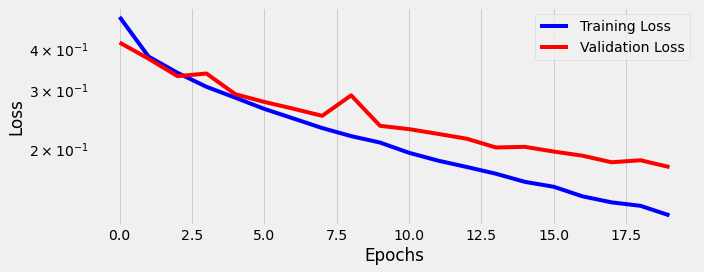

In [169]:
fig = sbs_doc_emb.plot_losses()

In [171]:
StepByStep.loader_apply(test_loader, sbs_doc_emb.correct)

tensor([[424, 440],
        [310, 331]])

# BERT

In [174]:
from transformers import AutoModel
auto_model = AutoModel.from_pretrained('bert-base-uncased')
print(auto_model.__class__)

<class 'transformers.models.bert.modeling_bert.BertModel'>


In [172]:
from transformers import BertModel
bert_model = BertModel.from_pretrained('bert-base-uncased')

In [173]:
bert_model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.5.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

## Tokenization

In [175]:
from transformers import BertTokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
len(bert_tokenizer.vocab)

30522

In [176]:
sentence1 = 'Alice is inexplicably following the white rabbit'
sentence2 = 'Follow the white rabbit, Neo'
tokens = bert_tokenizer(sentence1, sentence2, return_tensors='pt')
tokens

{'input_ids': tensor([[  101,  5650,  2003,  1999, 10288, 24759,  5555,  6321,  2206,  1996,
          2317, 10442,   102,  3582,  1996,  2317, 10442,  1010,  9253,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [177]:
print(bert_tokenizer.convert_ids_to_tokens(tokens['input_ids'][0]))

['[CLS]', 'alice', 'is', 'in', '##ex', '##pl', '##ica', '##bly', 'following', 'the', 'white', 'rabbit', '[SEP]', 'follow', 'the', 'white', 'rabbit', ',', 'neo', '[SEP]']


In [178]:
from transformers import AutoTokenizer
auto_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
print(auto_tokenizer.__class__)

<class 'transformers.models.bert.tokenization_bert_fast.BertTokenizerFast'>


## Input Embeddings

![](images/bert_input_embed.png)

In [179]:
input_embeddings = bert_model.embeddings
input_embeddings

BertEmbeddings(
  (word_embeddings): Embedding(30522, 768, padding_idx=0)
  (position_embeddings): Embedding(512, 768)
  (token_type_embeddings): Embedding(2, 768)
  (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [180]:
token_embeddings = input_embeddings.word_embeddings
token_embeddings

Embedding(30522, 768, padding_idx=0)

In [181]:
input_token_emb = token_embeddings(tokens['input_ids'])
input_token_emb

tensor([[[ 1.3630e-02, -2.6490e-02, -2.3503e-02,  ...,  8.6805e-03,
           7.1340e-03,  1.5147e-02],
         [-6.9710e-02, -8.8202e-02,  5.0619e-03,  ...,  1.4105e-02,
           2.1815e-02, -1.3769e-02],
         [-3.6044e-02, -2.4606e-02, -2.5735e-02,  ...,  3.3691e-03,
          -1.8300e-03,  2.6855e-02],
         ...,
         [ 5.2089e-05, -1.0468e-02, -9.9103e-03,  ...,  1.4558e-02,
           1.3217e-02,  2.2406e-02],
         [-3.5037e-02, -7.2933e-02, -3.6124e-02,  ..., -5.7723e-02,
          -5.5074e-03,  7.2688e-03],
         [-1.4521e-02, -9.9615e-03,  6.0263e-03,  ..., -2.5035e-02,
           4.6379e-03, -1.5378e-03]]], grad_fn=<EmbeddingBackward>)

In [182]:
position_embeddings = input_embeddings.position_embeddings
position_embeddings

Embedding(512, 768)

In [183]:
position_ids = torch.arange(512).expand((1, -1))
position_ids

tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
          28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
          42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
          56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
          70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
          84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
          98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
         112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
         126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
         140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
         154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
         168, 169, 170, 171, 172, 173, 174, 175, 176

In [184]:
seq_length = tokens['input_ids'].size(1)
input_pos_emb = position_embeddings(position_ids[:, :seq_length])
input_pos_emb

tensor([[[ 1.7505e-02, -2.5631e-02, -3.6642e-02,  ...,  3.3437e-05,
           6.8312e-04,  1.5441e-02],
         [ 7.7580e-03,  2.2613e-03, -1.9444e-02,  ...,  2.8910e-02,
           2.9753e-02, -5.3247e-03],
         [-1.1287e-02, -1.9644e-03, -1.1573e-02,  ...,  1.4908e-02,
           1.8741e-02, -7.3140e-03],
         ...,
         [-9.2809e-03,  8.3268e-03, -4.1643e-03,  ...,  3.4903e-02,
          -1.8319e-02, -2.9017e-03],
         [-8.5999e-03,  3.2205e-04, -2.1249e-03,  ...,  2.7744e-02,
          -7.2760e-03, -2.0280e-03],
         [-3.4622e-04, -8.3709e-04, -2.2228e-02,  ...,  2.3493e-02,
          -4.5198e-04, -5.7741e-04]]], grad_fn=<EmbeddingBackward>)

In [185]:
segment_embeddings = input_embeddings.token_type_embeddings
segment_embeddings

Embedding(2, 768)

In [186]:
input_seg_emb = segment_embeddings(tokens['token_type_ids'])
input_seg_emb

tensor([[[ 0.0004,  0.0110,  0.0037,  ..., -0.0066, -0.0034, -0.0086],
         [ 0.0004,  0.0110,  0.0037,  ..., -0.0066, -0.0034, -0.0086],
         [ 0.0004,  0.0110,  0.0037,  ..., -0.0066, -0.0034, -0.0086],
         ...,
         [ 0.0011, -0.0030, -0.0032,  ...,  0.0047, -0.0052, -0.0112],
         [ 0.0011, -0.0030, -0.0032,  ...,  0.0047, -0.0052, -0.0112],
         [ 0.0011, -0.0030, -0.0032,  ...,  0.0047, -0.0052, -0.0112]]],
       grad_fn=<EmbeddingBackward>)

In [187]:
input_emb = input_token_emb + input_pos_emb + input_seg_emb
input_emb

tensor([[[ 0.0316, -0.0411, -0.0564,  ...,  0.0021,  0.0044,  0.0219],
         [-0.0615, -0.0750, -0.0107,  ...,  0.0364,  0.0482, -0.0277],
         [-0.0469, -0.0156, -0.0336,  ...,  0.0117,  0.0135,  0.0109],
         ...,
         [-0.0081, -0.0051, -0.0172,  ...,  0.0542, -0.0103,  0.0083],
         [-0.0425, -0.0756, -0.0414,  ..., -0.0252, -0.0180, -0.0060],
         [-0.0138, -0.0138, -0.0194,  ...,  0.0032, -0.0011, -0.0133]]],
       grad_fn=<AddBackward0>)

## Pretraining Tasks

### Masked Language Model (MLM)

![](images/bert_mlm.png)

In [188]:
sentence = 'Alice is inexplicably following the white rabbit'
tokens = bert_tokenizer(sentence)
tokens['input_ids']

[101, 5650, 2003, 1999, 10288, 24759, 5555, 6321, 2206, 1996, 2317, 10442, 102]

In [189]:
from transformers import DataCollatorForLanguageModeling
torch.manual_seed(41)
data_collator = DataCollatorForLanguageModeling(tokenizer=bert_tokenizer, mlm_probability=0.15)
mlm_tokens = data_collator([tokens])
mlm_tokens

{'input_ids': tensor([[  101,  5650,  2003,  1999, 10288, 24759,   103,  6321,  2206,  1996,
          2317, 10442,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'labels': tensor([[-100, -100, -100, -100, -100, -100, 5555, -100, -100, -100, -100, -100,
         -100]])}

In [190]:
print(bert_tokenizer.convert_ids_to_tokens(tokens['input_ids']))
print(bert_tokenizer.convert_ids_to_tokens(mlm_tokens['input_ids'][0]))

['[CLS]', 'alice', 'is', 'in', '##ex', '##pl', '##ica', '##bly', 'following', 'the', 'white', 'rabbit', '[SEP]']
['[CLS]', 'alice', 'is', 'in', '##ex', '##pl', '[MASK]', '##bly', 'following', 'the', 'white', 'rabbit', '[SEP]']


### Next Sentence Prediction (NSP)

![](images/bert_nsp.png)

In [191]:
bert_model.pooler

BertPooler(
  (dense): Linear(in_features=768, out_features=768, bias=True)
  (activation): Tanh()
)

In [192]:
sentence1 = 'alice follows the white rabbit'
sentence2 = 'follow the white rabbit neo'
bert_tokenizer(sentence1, sentence2, return_tensors='pt')

{'input_ids': tensor([[  101,  5650,  4076,  1996,  2317, 10442,   102,  3582,  1996,  2317,
         10442,  9253,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

## Outputs

In [193]:
sentence = train_dataset[0]['sentence']
sentence

'And, so far as they knew, they were quite right.'

In [194]:
tokens = bert_tokenizer(sentence,
                        padding='max_length',
                        max_length=30, 
                        truncation=True, 
                        return_tensors="pt")
tokens

{'input_ids': tensor([[ 101, 1998, 1010, 2061, 2521, 2004, 2027, 2354, 1010, 2027, 2020, 3243,
         2157, 1012,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0]])}

In [195]:
bert_model.eval()
out = bert_model(input_ids=tokens['input_ids'], 
                 attention_mask=tokens['attention_mask'], 
                 output_attentions=True,
                 output_hidden_states=True,
                 return_dict=True)
out.keys()

odict_keys(['last_hidden_state', 'pooler_output', 'hidden_states', 'attentions'])

![](images/bert_embeddings.png)

In [196]:
last_hidden_batch = out['last_hidden_state']
last_hidden_sentence = last_hidden_batch[0]
# Removes hidden states for [PAD] tokens using the mask
mask = tokens['attention_mask'].squeeze().bool()
embeddings = last_hidden_sentence[mask]
# Removes embeddings for the first [CLS] and last [SEP] tokens
embeddings[1:-1]

tensor([[ 0.0100,  0.8575, -0.5429,  ...,  0.1661,  0.4241, -0.2035],
        [-0.3705,  1.1001,  0.3326,  ..., -0.4595,  0.0656, -0.5644],
        [-0.2947,  0.5797,  0.1997,  ..., -0.2929, -0.3062,  0.6690],
        ...,
        [ 0.0691,  0.7393,  0.0553,  ..., -0.1853, -0.4896, -0.4832],
        [-0.1566,  0.6177,  0.1536,  ..., -0.1396,  0.0904, -0.4917],
        [ 0.7511,  0.3110, -0.3116,  ...,  0.3498, -0.1740, -0.2337]],
       grad_fn=<SliceBackward>)

In [197]:
get_embeddings(bert_flair, sentence)

tensor([[ 0.0100,  0.8575, -0.5429,  ...,  0.1661,  0.4241, -0.2035],
        [-0.3705,  1.1001,  0.3326,  ..., -0.4595,  0.0656, -0.5644],
        [-0.2947,  0.5797,  0.1997,  ..., -0.2929, -0.3062,  0.6690],
        ...,
        [ 0.0691,  0.7393,  0.0552,  ..., -0.1853, -0.4896, -0.4832],
        [-0.1566,  0.6177,  0.1536,  ..., -0.1396,  0.0904, -0.4917],
        [ 0.7511,  0.3110, -0.3116,  ...,  0.3498, -0.1740, -0.2337]],
       device='cuda:0')

In [198]:
print(len(out['hidden_states']))
print(out['hidden_states'][0].shape)

13
torch.Size([1, 30, 768])


In [199]:
(out['hidden_states'][0] == bert_model.embeddings(tokens['input_ids'])).all()

tensor(True)

In [200]:
(out['hidden_states'][-1] == out['last_hidden_state']).all()

tensor(True)

In [201]:
(out['pooler_output'] == bert_model.pooler(out['last_hidden_state'])).all()

tensor(True)

In [202]:
print(len(out['attentions']))
print(out['attentions'][0].shape)

12
torch.Size([1, 12, 30, 30])


## Model IV - Classifying using BERT

In [203]:
class BERTClassifier(nn.Module):
    def __init__(self, bert_model, ff_units, n_outputs, dropout=0.3):
        super().__init__()
        self.d_model = bert_model.config.dim
        self.n_outputs = n_outputs
        self.encoder = bert_model
        self.mlp = nn.Sequential(
            nn.Linear(self.d_model, ff_units),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_units, n_outputs)
        )
        
    def encode(self, source, source_mask=None):
        states = self.encoder(input_ids=source, 
                              attention_mask=source_mask)[0]
        cls_state = states[:, 0]
        return cls_state

    def forward(self, X):
        source_mask = (X > 0)
        # Featurizer
        cls_state = self.encode(X, source_mask)
        # Classifier
        out = self.mlp(cls_state)
        return out

### Data Preparation

In [204]:
def tokenize_dataset(hf_dataset, sentence_field, label_field, tokenizer, **kwargs):
    sentences = hf_dataset[sentence_field]
    token_ids = tokenizer(sentences, return_tensors='pt', **kwargs)['input_ids']
    labels = torch.as_tensor(hf_dataset[label_field])
    dataset = TensorDataset(token_ids, labels)
    return dataset

In [205]:
auto_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
tokenizer_kwargs = dict(truncation=True, padding=True, max_length=30, add_special_tokens=True)

In [206]:
train_dataset_float = train_dataset.map(lambda row: {'labels': [float(row['labels'])]})
test_dataset_float = test_dataset.map(lambda row: {'labels': [float(row['labels'])]})

train_tensor_dataset = tokenize_dataset(train_dataset_float, 'sentence', 'labels', auto_tokenizer, **tokenizer_kwargs)
test_tensor_dataset = tokenize_dataset(test_dataset_float, 'sentence', 'labels', auto_tokenizer, **tokenizer_kwargs)

generator = torch.Generator()
train_loader = DataLoader(train_tensor_dataset, batch_size=4, shuffle=True, generator=generator)
test_loader = DataLoader(test_tensor_dataset, batch_size=8)

### Model Configuration & Training

In [207]:
torch.manual_seed(41)
bert_model = AutoModel.from_pretrained("distilbert-base-uncased")
model = BERTClassifier(bert_model, 128, n_outputs=1)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [208]:
sbs_bert = StepByStep(model, loss_fn, optimizer)
sbs_bert.set_loaders(train_loader, test_loader)
sbs_bert.train(1)

In [209]:
sbs_bert.count_parameters()

66461441

In [210]:
StepByStep.loader_apply(test_loader, sbs_bert.correct)

tensor([[424, 440],
        [317, 331]])

# Fine-Tuning with HuggingFace

## Sequence Classification (or Regression)

In [211]:
from transformers import DistilBertForSequenceClassification
torch.manual_seed(42)
bert_cls = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [212]:
from transformers import AutoModelForSequenceClassification
auto_cls = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
print(auto_cls.__class__)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

<class 'transformers.models.distilbert.modeling_distilbert.DistilBertForSequenceClassification'>


## Tokenized Dataset

In [213]:
auto_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
def tokenize(row):
    return auto_tokenizer(row['sentence'], 
                          truncation=True, 
                          padding='max_length',
                          max_length=30)

In [214]:
tokenized_train_dataset = train_dataset.map(tokenize, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize, batched=True)

In [215]:
print(tokenized_train_dataset[0])

{'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'input_ids': [101, 1998, 1010, 2061, 2521, 2004, 2027, 2354, 1010, 2027, 2020, 3243, 2157, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': 0, 'sentence': 'And, so far as they knew, they were quite right.', 'source': 'wizoz10-1740.txt'}


In [216]:
tokenized_train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
tokenized_test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

In [217]:
tokenized_train_dataset[0]

{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0]),
 'input_ids': tensor([ 101, 1998, 1010, 2061, 2521, 2004, 2027, 2354, 1010, 2027, 2020, 3243,
         2157, 1012,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0]),
 'labels': tensor(0)}

## Trainer

In [218]:
from transformers import Trainer
trainer = Trainer(model=bert_cls, train_dataset=tokenized_train_dataset)

In [219]:
trainer.args

TrainingArguments(output_dir=tmp_trainer, overwrite_output_dir=False, do_train=False, do_eval=None, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=8, per_device_eval_batch_size=8, gradient_accumulation_steps=1, eval_accumulation_steps=None, learning_rate=5e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=3.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/Apr21_20-33-20_MONSTER, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, save_total_limit=None, no_cuda=False, seed=42, fp16=False, fp16_opt_level=O1, fp16_backend=auto, fp16_full_eval=False, local_rank=-1, tpu_num_cores=None, tpu_metrics_debug=False, debug=False, dataloader_drop_last=False, eval_steps=500, dataloader_num_workers=0, past_index=-1, run_name=tm

In [220]:
from transformers import TrainingArguments
training_args = TrainingArguments(
    output_dir='output',
    num_train_epochs=1,             
    per_device_train_batch_size=1,
    per_device_eval_batch_size=8,
    evaluation_strategy='steps',
    eval_steps=300,
    logging_steps=300,
    gradient_accumulation_steps=8,
)

In [221]:
def compute_metrics(eval_pred):
    predictions = eval_pred.predictions
    labels = eval_pred.label_ids
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": (predictions == labels).mean()}

In [222]:
trainer = Trainer(model=bert_cls, 
                  args=training_args, 
                  train_dataset=tokenized_train_dataset, 
                  eval_dataset=tokenized_test_dataset,
                  compute_metrics=compute_metrics)

In [223]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
300,0.194600,0.159694,0.953307,1.648500,467.697000


TrainOutput(global_step=385, training_loss=0.17661244776341822, metrics={'train_runtime': 80.0324, 'train_samples_per_second': 4.811, 'total_flos': 37119857544000.0, 'epoch': 1.0, 'init_mem_cpu_alloc_delta': 0, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 5025792, 'train_mem_gpu_alloc_delta': 806599168, 'train_mem_cpu_peaked_delta': 0, 'train_mem_gpu_peaked_delta': 96468992})

In [224]:
trainer.evaluate()

{'eval_loss': 0.142591193318367,
 'eval_accuracy': 0.9610894941634242,
 'eval_runtime': 1.6634,
 'eval_samples_per_second': 463.51,
 'epoch': 1.0,
 'eval_mem_cpu_alloc_delta': 0,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 0,
 'eval_mem_gpu_peaked_delta': 8132096}

In [225]:
trainer.save_model('bert_alice_vs_wizard')
os.listdir('bert_alice_vs_wizard')

['training_args.bin', 'config.json', 'pytorch_model.bin']

In [226]:
loaded_model = AutoModelForSequenceClassification.from_pretrained('bert_alice_vs_wizard')
loaded_model.device

device(type='cpu')

In [227]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
loaded_model.to(device)
loaded_model.device

device(type='cuda', index=0)

## Predictions

In [228]:
sentence = 'Down the yellow brick rabbit hole'
tokens = auto_tokenizer(sentence, return_tensors='pt')
tokens

{'input_ids': tensor([[  101,  2091,  1996,  3756,  5318, 10442,  4920,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}

In [229]:
print(type(tokens))
tokens.to(loaded_model.device)

<class 'transformers.tokenization_utils_base.BatchEncoding'>


{'input_ids': tensor([[  101,  2091,  1996,  3756,  5318, 10442,  4920,   102]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

In [230]:
loaded_model.eval()
logits = loaded_model(input_ids=tokens['input_ids'], attention_mask=tokens['attention_mask'])
logits

SequenceClassifierOutput(loss=None, logits=tensor([[ 2.7745, -2.5539]], device='cuda:0', grad_fn=<AddmmBackward>), hidden_states=None, attentions=None)

In [233]:
logits.logits.argmax(dim=1)

tensor([0], device='cuda:0')

## Pipeline

In [234]:
from transformers import TextClassificationPipeline
device_index = loaded_model.device.index if loaded_model.device.type != 'cpu' else -1
classifier = TextClassificationPipeline(model=loaded_model,
                                        tokenizer=auto_tokenizer, 
                                        device=device_index)

In [235]:
classifier(['Down the Yellow Brick Rabbit Hole', 'Alice rules!'])

[{'label': 'LABEL_0', 'score': 0.9951714277267456},
 {'label': 'LABEL_1', 'score': 0.9985325336456299}]

In [236]:
loaded_model.config.id2label = {0: 'Wizard', 1: 'Alice'}

In [237]:
classifier(['Down the Yellow Brick Rabbit Hole', 'Alice rules!'])

[{'label': 'Wizard', 'score': 0.9951714277267456},
 {'label': 'Alice', 'score': 0.9985325336456299}]

## More Pipelines

In [238]:
from transformers import pipeline
sentiment = pipeline('sentiment-analysis')

In [239]:
sentence = train_dataset[0]['sentence']
print(sentence)
print(sentiment(sentence))

And, so far as they knew, they were quite right.
[{'label': 'POSITIVE', 'score': 0.9998356699943542}]


In [240]:
from transformers.pipelines import SUPPORTED_TASKS
SUPPORTED_TASKS['sentiment-analysis'] # 'text-classification' from v4.6.0 on

{'impl': transformers.pipelines.text_classification.TextClassificationPipeline,
 'tf': None,
 'pt': types.AutoModelForSequenceClassification,
 'default': {'model': {'pt': 'distilbert-base-uncased-finetuned-sst-2-english',
   'tf': 'distilbert-base-uncased-finetuned-sst-2-english'}}}

In [241]:
SUPPORTED_TASKS['text-generation']

{'impl': transformers.pipelines.text_generation.TextGenerationPipeline,
 'tf': None,
 'pt': types.AutoModelForCausalLM,
 'default': {'model': {'pt': 'gpt2', 'tf': 'gpt2'}}}

# GPT-2

In [242]:
text_generator = pipeline("text-generation")

In [243]:
text_generator.model.config.task_specific_params

{'text-generation': {'do_sample': True, 'max_length': 50}}

In [21]:
base_text = """
Alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do:  once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations in it, `and what is the use of a book,'thought Alice `without pictures or conversation?' So she was considering in her own mind (as well as she could, for the hot day made her feel very sleepy and stupid), whether the pleasure of making a daisy-chain would be worth the trouble of getting up and picking the daisies, when suddenly a White Rabbit with pink eyes ran close by her.
"""

In [245]:
result = text_generator(base_text, max_length=250)
print(result[0]['generated_text'])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do:  once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations in it, `and what is the use of a book,'thought Alice `without pictures or conversation?' So she was considering in her own mind (as well as she could, for the hot day made her feel very sleepy and stupid), whether the pleasure of making a daisy-chain would be worth the trouble of getting up and picking the daisies, when suddenly a White Rabbit with pink eyes ran close by her.

After about a week, when Alice had finished reading about animals and people, the White Rabbit went up to the dining-room door. 'Sir,'she said, `you have to see a White Rabbit!' she said, `and what was it about it that struck you?'

Alice smiled. 'It was just to tell you.'

'Then I had no idea,' said Alice, `that it was like a book. But it does seem to me (like a book,)a book of dreams. I have tried it 

# Putting It All Together

## Data Preparation

In [5]:
dataset = load_dataset(path='csv', data_files=['texts/alice28-1476.sent.csv'], quotechar='\\', split=Split.TRAIN)

Using custom data configuration default-b2e45ba3a816baa2
Reusing dataset csv (/home/dvgodoy/.cache/huggingface/datasets/csv/default-b2e45ba3a816baa2/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0)


In [6]:
shuffled_dataset = dataset.shuffle(seed=42)
split_dataset = shuffled_dataset.train_test_split(test_size=0.2, seed=42)
train_dataset, test_dataset = split_dataset['train'], split_dataset['test']

In [7]:
auto_tokenizer = AutoTokenizer.from_pretrained('gpt2')
def tokenize(row):
    return auto_tokenizer(row['sentence'])

In [8]:
tokenized_train_dataset = train_dataset.map(tokenize, remove_columns=['source', 'sentence'], batched=True)
tokenized_test_dataset = test_dataset.map(tokenize, remove_columns=['source', 'sentence'], batched=True)

In [9]:
list(map(len, tokenized_train_dataset[0:6]['input_ids']))

[9, 28, 20, 9, 34, 29]

### "Packed" Dataset

![](images/block_tokens.png)

In [10]:
# Adapted from https://github.com/huggingface/transformers/blob/master/examples/pytorch/language-modeling/run_clm.py
def group_texts(examples, block_size=128):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
    # customize this part to your needs.
    total_length = (total_length // block_size) * block_size
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

In [11]:
lm_train_dataset = tokenized_train_dataset.map(group_texts, batched=True)
lm_test_dataset = tokenized_test_dataset.map(group_texts, batched=True)
lm_train_dataset.set_format(type='torch')
lm_test_dataset.set_format(type='torch')

In [12]:
print(lm_train_dataset[0]['input_ids'])

tensor([   63,  2437,   466,   345,   760,   314,  1101,  8805,  8348,   464,
         2677,  3114,  7296,  6819,   379,   262,  2635, 25498,    11,   508,
          531,   287,   257,  1877,  3809,    11,  4600,  7120, 25788,  1276,
         3272,    12,  1069,  9862, 12680,  4973,  2637,  1537,   611,   314,
         1101,   407,   262,   976,    11,   262,  1306,  1808,   318,    11,
         5338,   287,   262,   995,   716,   314,    30,   464,   360,   579,
         1076,  6364,  4721,   465,  2951,    13,    63,  1026,   373,   881,
        21289,   272,   353,   379,  1363,  4032,  1807,  3595, 14862,    11,
         4600, 12518,   530,  2492,   470,  1464,  3957,  4025,   290,  4833,
           11,   290,   852,  6149,   546,   416, 10693,   290, 33043,    13,
         1870, 14862,   373,   523,   881, 24776,   326,   673,  4966,   572,
          379,  1752,   287,   262,  4571,   340,  6235,   284,    11,  1231,
         2111,   284,  4727,   262,  7457,   340,   550,   925])

In [13]:
len(lm_train_dataset), len(lm_test_dataset)

(239, 56)

## Model Configuration & Training

In [14]:
from transformers import AutoModelForCausalLM
model = AutoModelForCausalLM.from_pretrained('gpt2')
print(model.__class__)

<class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'>


In [15]:
model.resize_token_embeddings(len(auto_tokenizer))

Embedding(50257, 768)

In [16]:
training_args = TrainingArguments(
    output_dir='output',
    num_train_epochs=1,             
    per_device_train_batch_size=1,
    per_device_eval_batch_size=8,
    evaluation_strategy='steps',
    eval_steps=50,
    logging_steps=50,
    gradient_accumulation_steps=4,
    prediction_loss_only=True,
)

trainer = Trainer(model=model, 
                  args=training_args, 
                  train_dataset=lm_train_dataset, 
                  eval_dataset=lm_test_dataset)

In [17]:
trainer.train()

Step,Training Loss,Validation Loss,Runtime,Samples Per Second
50,3.587500,3.327199,0.891100,62.845000


TrainOutput(global_step=59, training_loss=3.5507330167091498, metrics={'train_runtime': 22.6958, 'train_samples_per_second': 2.6, 'total_flos': 22554466320384.0, 'epoch': 0.99, 'init_mem_cpu_alloc_delta': 1316954112, 'init_mem_gpu_alloc_delta': 511148032, 'init_mem_cpu_peaked_delta': 465375232, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 13103104, 'train_mem_gpu_alloc_delta': 1499219456, 'train_mem_cpu_peaked_delta': 0, 'train_mem_gpu_peaked_delta': 730768896})

In [18]:
trainer.evaluate()

{'eval_loss': 3.320632219314575,
 'eval_runtime': 0.9266,
 'eval_samples_per_second': 60.438,
 'epoch': 0.99,
 'eval_mem_cpu_alloc_delta': 151552,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 0,
 'eval_mem_gpu_peaked_delta': 730768896}

## Generating Text

In [19]:
device_index = model.device.index if model.device.type != 'cpu' else -1
gpt2_gen = pipeline('text-generation', model=model, tokenizer=auto_tokenizer, device=device_index)

In [22]:
result = gpt2_gen(base_text, max_length=250)
print(result[0]['generated_text'])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do:  once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations in it, `and what is the use of a book,'thought Alice `without pictures or conversation?' So she was considering in her own mind (as well as she could, for the hot day made her feel very sleepy and stupid), whether the pleasure of making a daisy-chain would be worth the trouble of getting up and picking the daisies, when suddenly a White Rabbit with pink eyes ran close by her.
`Oh, the way you were,'said Alice; `you've done your best to put it right--'and the Rabbit began to laugh, and it stopped.`Oh!--that's a bad feeling, indeed,'said Alice, `and that's certainly no good, or at all pleasant, to you.`You know, there is just an hour!'The Rabbit said timidly--as she stood up a bit, and looked at the room again.`As you like it,'said Alice again, `you've been talking!'--and she r